In [20]:
import numpy as np
from typing import Dict, List, Optional, Tuple, Union, Any
from pyunicorn.timeseries import RecurrencePlot
import os
import matplotlib.pyplot as plt

In [23]:
def compute_rqa_metrics_for_window(
    window_signal: np.ndarray,
    embedding_dim: int,
    time_delay: int,
    radius: float,
    distance_metric: str,
    min_diagonal_line: int = 2,
    min_vertical_line: int = 2,
    min_white_vertical_line: int = 1,
    metrics_to_use: Optional[List[str]] = None,
    cache_recurrence_plot: bool = False,
    lag_values: List[int] = [0],
    resample_count: int = 1000,
    calculate_twins: bool = False,
    n_surrogates: int = 0,
    min_twin_dist: int = 7,
) -> Tuple[Dict[str, Any], Optional[RecurrencePlot]]:
    """
    Compute RQA metrics from a windowed signal using RecurrencePlot.

    This function calculates a variety of RQA measures and related
    quantities for a given signal window. It optionally returns
    the RecurrencePlot object for re-use.

    Parameters:
    -----------
    window_signal : np.ndarray
        Signal window to analyze.
    embedding_dim : int
        The embedding dimension for phase-space reconstruction.
    time_delay : int
        The embedding time delay.
    radius : float
        The radius for determining recurrences in phase space.
    distance_metric : str
        The distance metric to use ("euclidean", "manhattan", "supremum", "meandist").
    min_diagonal_line : int
        Minimum diagonal line length for diagonal-based RQA metrics.
    min_vertical_line : int
        Minimum vertical line length for vertical-based RQA metrics.
    min_white_vertical_line : int
        Minimum white vertical line length for white-vertical-based RQA metrics.
    metrics_to_use : Optional[List[str]]
        List of metric names to compute. If None, all are computed.
    cache_recurrence_plot : bool
        If True, return the RecurrencePlot object.
    lag_values : List[int]
        List of lag values to use for recurrence probability calculations.
    resample_count : int
        Number of resamplings for the resampled distributions.
    calculate_twins : bool
        Whether to compute twin-based metrics (more computationally intensive).
    n_surrogates : int
        Number of twin surrogates to generate (0 means don't compute).
    min_twin_dist : int
        Minimum temporal distance for twins.

    Returns:
    --------
    metrics : Dict[str, Any]
        A dictionary of computed metrics (floats, arrays, or sub-dicts).
    rp : Optional[RecurrencePlot]
        The RecurrencePlot object if cache_recurrence_plot is True,
        otherwise None.
    """
    # If user doesn't request a specific set of metrics, compute them all
    all_possible_metrics = [
        "RR",               # Recurrence Rate
        "DET",              # Determinism
        "L_max",            # Max diagonal line length
        "L_mean",           # Mean diagonal line length
        "ENT",              # Diagonal line entropy
        "LAM",              # Laminarity 
        "TT",               # Trapping time (alias of average_vertlength)
        "V_max",            # Max vertical line length
        "V_mean",           # Mean vertical line length
        "V_ENT",            # Vertical line entropy
        "W_max",            # Max white vertical line length
        "W_mean",           # Mean white vertical line length (mean recurrence time)
        "W_ENT",            # White vertical line entropy
        "CLEAR",            # Complexity entropy
        "PERM_ENT",         # Permutation entropy
        "REC_PROB",         # Recurrence probability (lag=0 by default)
        "DIAG_DIST",        # Frequency distribution of diagonal line lengths
        "VERT_DIST",        # Frequency distribution of vertical line lengths
        "WHITE_VERT_DIST",  # Frequency distribution of white vertical line lengths
        "RQA_SUMMARY",      # Returns "RR", "DET", average diagonal length, "LAM"
        "RESAMPLE_DIAG_DIST",  # Resampled diag-line distribution
        "RESAMPLE_VERT_DIST",  # Resampled vert-line distribution
        "TWINS",            # List of twins for each state vector
        "TWIN_SURROGATES",  # Twin surrogate trajectories
    ]
    if metrics_to_use is None:
        metrics_to_use = all_possible_metrics

    # Special handling if the user wants to normalize 'radius' by the mean distance
    # from the signal (option "meandist" as the distance metric)
    if distance_metric.lower() == "meandist":
        from scipy.spatial.distance import pdist

        distances = pdist(window_signal.reshape(-1, 1), metric="euclidean")
        mean_dist = np.mean(distances) if len(distances) > 0 else 1.0
        normalized_radius = radius / mean_dist
        actual_radius = normalized_radius
        distance_metric = "euclidean"
    else:
        actual_radius = radius

    # Build the RecurrencePlot
    rp = RecurrencePlot(
        time_series=window_signal,
        dim=embedding_dim,
        tau=time_delay,
        metric=distance_metric,
        threshold=actual_radius,
        silence_level=2,
    )

    # Define metric computation in lambdas
    metric_functions = {
        "RR": lambda: rp.recurrence_rate(),
        "DET": lambda: rp.determinism(l_min=min_diagonal_line),
        "L_max": lambda: rp.max_diaglength(),
        "L_mean": lambda: rp.average_diaglength(l_min=min_diagonal_line),
        "ENT": lambda: rp.diag_entropy(l_min=min_diagonal_line),
        "LAM": lambda: rp.laminarity(v_min=min_vertical_line),
        "TT": lambda: rp.trapping_time(v_min=min_vertical_line),
        "V_max": lambda: rp.max_vertlength(),
        "V_mean": lambda: rp.average_vertlength(v_min=min_vertical_line),
        "V_ENT": lambda: rp.vert_entropy(v_min=min_vertical_line),
        "W_max": lambda: rp.max_white_vertlength(),
        "W_mean": lambda: rp.average_white_vertlength(w_min=min_white_vertical_line),
        "W_ENT": lambda: rp.white_vert_entropy(w_min=min_white_vertical_line),
        # Additional entropies (check attribute existence for older pyunicorn)
        "CLEAR": lambda: rp.complexity_entropy() if hasattr(rp, "complexity_entropy") else None,
        "PERM_ENT": lambda: rp.permutation_entropy() if hasattr(rp, "permutation_entropy") else None,
        "DIAG_DIST": lambda: rp.diagline_dist(),         # Array
        "VERT_DIST": lambda: rp.vertline_dist(),         # Array
        "WHITE_VERT_DIST": lambda: rp.white_vertline_dist(),  # Array
        "RQA_SUMMARY": lambda: rp.rqa_summary(l_min=min_diagonal_line,
                                             v_min=min_vertical_line),
        # Resampling calls for confidence intervals
        "RESAMPLE_DIAG_DIST": lambda: rp.resample_diagline_dist(M=resample_count),
        "RESAMPLE_VERT_DIST": lambda: rp.resample_vertline_dist(M=resample_count),
        # Twin-based metrics
        "TWINS": lambda: rp.twins(min_dist=min_twin_dist) if calculate_twins else None,
        "TWIN_SURROGATES": lambda: rp.twin_surrogates(n_surrogates=n_surrogates, min_dist=min_twin_dist) 
                                   if calculate_twins and n_surrogates > 0 else None,
    }
    
    # Add recurrence probability for different lag values
    for lag in lag_values:
        metric_name = f"REC_PROB_LAG_{lag}"
        metric_functions[metric_name] = lambda lag=lag: rp.recurrence_probability(lag=lag)
        if metrics_to_use == all_possible_metrics:
            metrics_to_use.append(metric_name)

    metrics = {}
    for metric_name in metrics_to_use:
        if metric_name in metric_functions:
            try:
                metrics[metric_name] = metric_functions[metric_name]()
            except Exception as e:
                # If there's a computation error, store None and the error message
                metrics[metric_name] = None
                metrics[f"{metric_name}_error"] = str(e)
        else:
            # Requested metric not defined
            metrics[metric_name] = None

    if cache_recurrence_plot:
        return metrics, rp
    else:
        return metrics, None

In [21]:
def load_eeg_data(
    path: str = "/home/mariopasc/Python/Datasets/EEG/timeseries/processed/zerolag",
    patient_idx: int = 0,
    channel_idx: int = 11,  # T7
    band_idx: int = 4,      # Gamma
    group: str = "both"     # "DD", "CT", or "both"
) -> Dict[str, np.ndarray]:
    """
    Load EEG data for selected patient, channel, and frequency band.
    
    Parameters:
    -----------
    path : str
        Path to the directory containing the data files
    patient_idx : int
        Patient index
    channel_idx : int
        Channel index (11 = T7)
    band_idx : int
        Frequency band index (4 = Gamma)
    group : str
        Which group to load: "DD" (dyslexia), "CT" (control), or "both"
        
    Returns:
    --------
    Dict[str, np.ndarray]
        Dictionary with keys "DD" and/or "CT" containing the timeseries data
    """
    data = {}
    
    if group.lower() in ["dd", "both"]:
        dd = np.load(os.path.join(path, "DD_UP_preprocess_2.npz"))["data"]
        data["DD"] = dd[patient_idx, channel_idx, :, band_idx]
        
    if group.lower() in ["ct", "both"]:
        ct = np.load(os.path.join(path, "CT_UP_preprocess_2.npz"))["data"]
        data["CT"] = ct[patient_idx, channel_idx, :, band_idx]
    
    return data

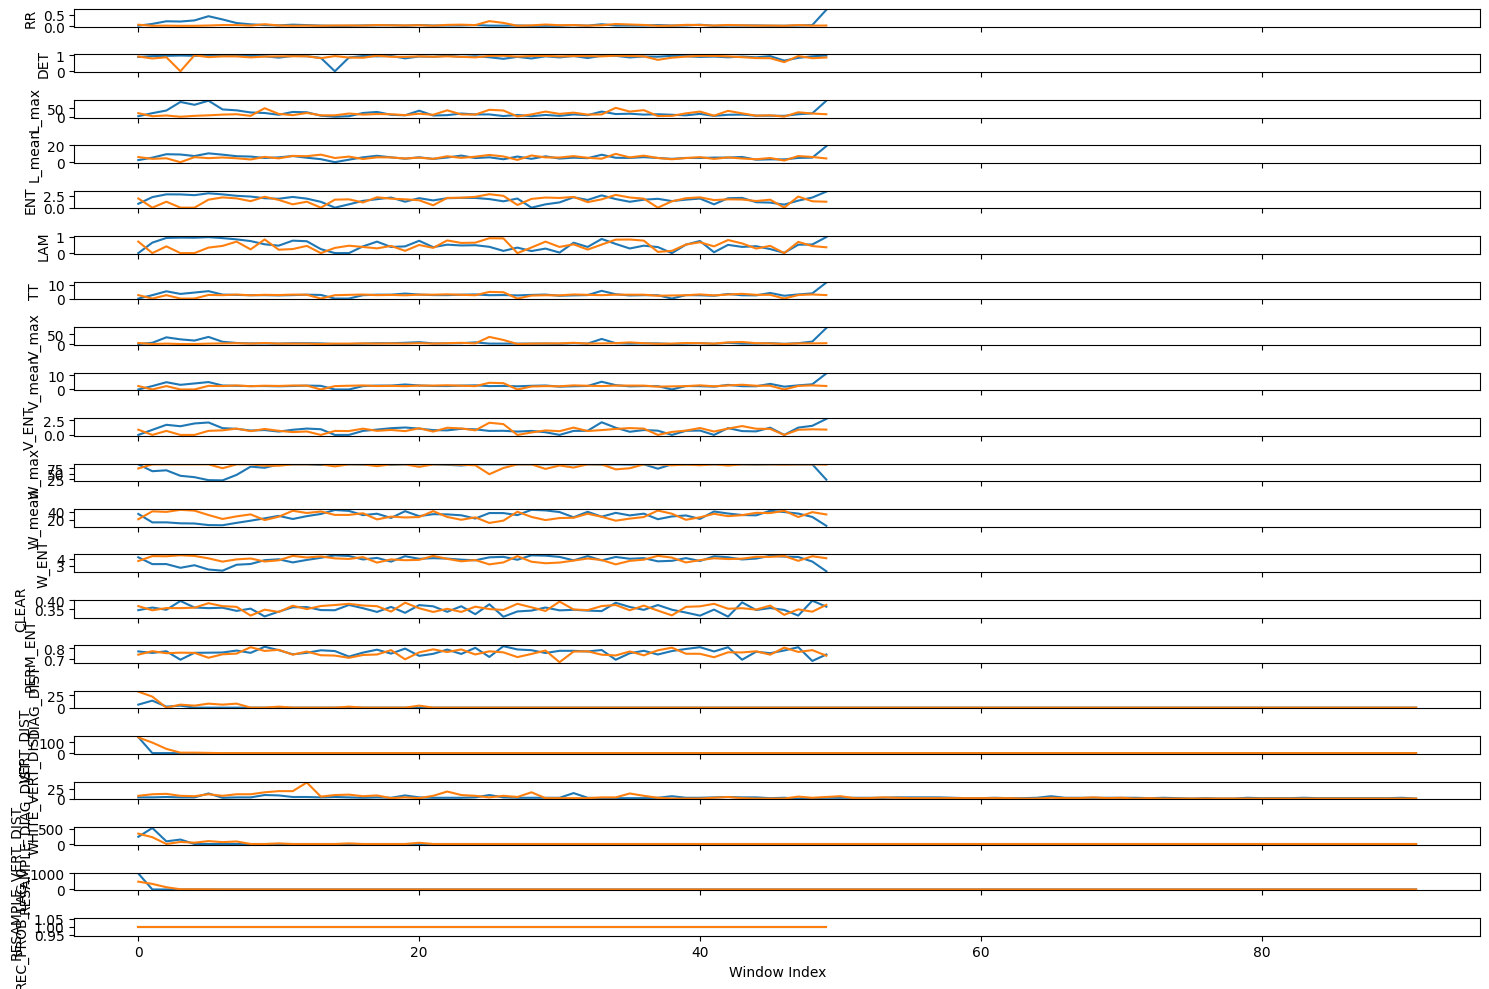

In [35]:
def compute_windowed_rqa_metrics(
    signal: np.ndarray,
    embedding_dim: int,
    time_delay: int,
    radius: float,
    distance_metric: str,
    window_size: int,
    stride: int,
    metrics_to_use: List[str],
    min_diagonal_line: int = 2,
    min_vertical_line: int = 2,
    min_white_vertical_line: int = 1,
    batch_size: Optional[int] = None,
    lag_values: List[int] = [0],
    resample_count: int = 1000,
    calculate_twins: bool = False,
    n_surrogates: int = 0,
    min_twin_dist: int = 7,
    return_dict: bool = False
) -> Union[np.ndarray, Dict[str, np.ndarray]]:
    """
    Compute RQA metrics for windows of a signal using sliding window approach.
    
    Parameters:
    -----------
    signal : np.ndarray
        Input signal (1D time series)
    embedding_dim : int
        Embedding dimension for phase space reconstruction
    time_delay : int
        Time delay for embedding
    radius : float
        Radius threshold for recurrence plot
    distance_metric : str
        Distance metric ("euclidean", "manhattan", "supremum", "meandist")
    window_size : int
        Size of each window in samples
    stride : int
        Step size between consecutive windows in samples
    metrics_to_use : List[str]
        List of RQA metric names to compute for each window
    min_diagonal_line : int
        Minimum diagonal line length for RQA metrics
    min_vertical_line : int
        Minimum vertical line length for RQA metrics
    min_white_vertical_line : int
        Minimum white vertical line length for RQA metrics
    batch_size : Optional[int]
        Number of windows to process (None = all possible windows)
    lag_values : List[int] 
        List of lag values for recurrence probability calculation
    resample_count : int
        Number of resamplings for distribution metrics
    calculate_twins : bool
        Whether to compute twin-based metrics
    n_surrogates : int
        Number of twin surrogates to generate
    min_twin_dist : int
        Minimum temporal distance for twins
    return_dict : bool
        If True, return a dictionary with metric names as keys,
        otherwise return a 2D array (windows x metrics)
        
    Returns:
    --------
    Union[np.ndarray, Dict[str, np.ndarray]]
        Either a 2D array of shape (n_windows, n_metrics) with RQA values
        or a dictionary with metric names as keys and arrays of values as values
    """
    n = len(signal)
    num_windows = (n - window_size) // stride + 1

    if batch_size is None or batch_size >= num_windows:
        batch_size = num_windows
    
    # First, process a sample window to get all the metrics that will be computed
    # (including dynamically generated ones like REC_PROB_LAG_X)
    sample_window = signal[:window_size]
    sample_metrics, _ = compute_rqa_metrics_for_window(
        window_signal=sample_window,
        embedding_dim=embedding_dim,
        time_delay=time_delay,
        radius=radius,
        distance_metric=distance_metric,
        min_diagonal_line=min_diagonal_line,
        min_vertical_line=min_vertical_line,
        min_white_vertical_line=min_white_vertical_line,
        metrics_to_use=metrics_to_use,
        lag_values=lag_values,
        resample_count=resample_count,
        calculate_twins=calculate_twins,
        n_surrogates=n_surrogates,
        min_twin_dist=min_twin_dist
    )
    
    # Get all metrics that will be returned, including dynamically generated ones
    all_metrics = list(sample_metrics.keys())
    # Remove error messages
    all_metrics = [m for m in all_metrics if not m.endswith('_error')]
    
    # Initialize results storage
    if return_dict:
        results_dict = {}
        for metric in all_metrics:
            if metric in sample_metrics and sample_metrics[metric] is not None:
                if isinstance(sample_metrics[metric], (np.ndarray, list)):
                    # For array metrics, just store the sample window's value
                    results_dict[metric] = sample_metrics[metric]
                elif np.isscalar(sample_metrics[metric]):
                    # For scalar metrics, initialize an array for all windows
                    results_dict[metric] = np.full(batch_size, np.nan)
    else:
        # Filter to only scalar metrics for array return
        scalar_metrics = [m for m in all_metrics if 
                        m in sample_metrics and 
                        sample_metrics[m] is not None and 
                        np.isscalar(sample_metrics[m])]
        # Pre-allocate results array
        rqa_results = np.full((batch_size, len(scalar_metrics)), np.nan)

    for i in range(batch_size):
        start_idx = i * stride
        window_data = signal[start_idx : start_idx + window_size]

        metrics, _ = compute_rqa_metrics_for_window(
            window_signal=window_data,
            embedding_dim=embedding_dim,
            time_delay=time_delay,
            radius=radius,
            distance_metric=distance_metric,
            min_diagonal_line=min_diagonal_line,
            min_vertical_line=min_vertical_line,
            min_white_vertical_line=min_white_vertical_line,
            metrics_to_use=metrics_to_use,
            lag_values=lag_values,
            resample_count=resample_count,
            calculate_twins=calculate_twins,
            n_surrogates=n_surrogates,
            min_twin_dist=min_twin_dist
        )
        
        # Store the results
        if return_dict:
            for metric_name in all_metrics:
                if metric_name in metrics and metrics[metric_name] is not None:
                    # Only update scalar metrics after the first window
                    if np.isscalar(metrics[metric_name]) and metric_name in results_dict:
                        results_dict[metric_name][i] = metrics[metric_name]
        else:
            for j, metric_name in enumerate(scalar_metrics):
                if metric_name in metrics and metrics[metric_name] is not None:
                    if np.isscalar(metrics[metric_name]):
                        rqa_results[i, j] = metrics[metric_name]
    
    if return_dict:
        return results_dict
    else:
        return rqa_results, scalar_metrics  # Return metric names so caller knows the columns


all_possible_metrics = [
    "RR",               # Recurrence Rate
    "DET",              # Determinism
    "L_max",            # Max diagonal line length
    "L_mean",           # Mean diagonal line length
    "ENT",              # Diagonal line entropy
    "LAM",              # Laminarity 
    "TT",               # Trapping time (alias of average_vertlength)
    "V_max",            # Max vertical line length
    "V_mean",           # Mean vertical line length
    "V_ENT",            # Vertical line entropy
    "W_max",            # Max white vertical line length
    "W_mean",           # Mean white vertical line length (mean recurrence time)
    "W_ENT",            # White vertical line entropy
    "CLEAR",            # Complexity entropy
    "PERM_ENT",         # Permutation entropy
    "REC_PROB",         # Recurrence probability (lag=0 by default)
    "DIAG_DIST",        # Frequency distribution of diagonal line lengths
    "VERT_DIST",        # Frequency distribution of vertical line lengths
    "WHITE_VERT_DIST",  # Frequency distribution of white vertical line lengths
    "RQA_SUMMARY",      # Returns "RR", "DET", average diagonal length, "LAM"
    "RESAMPLE_DIAG_DIST",  # Resampled diag-line distribution
    "RESAMPLE_VERT_DIST",  # Resampled vert-line distribution
    "TWINS",            # List of twins for each state vector
    "TWIN_SURROGATES",  # Twin surrogate trajectories
]

data = load_eeg_data(
    patient_idx=0,
    channel_idx=11,  # T7
    band_idx=4,      # Gamma
    group="both"
)
# Setup parameters
params = {
    "embedding_dim": 5,
    "time_delay": 2,
    "radius": 0.2,
    "distance_metric": "euclidean",
    "window_size": 100,
    "stride": 100,
    "metrics_to_use": all_possible_metrics,
    "batch_size": 50 
}

# Compute RQA metrics for both groups
results = {}
for group, signal in data.items():
    results[group] = compute_windowed_rqa_metrics(
        signal=signal,
        **params,
        return_dict=True
    )

# Plot some results
metrics_to_plot = ['RR', 'DET', 'L_max', 'L_mean', 'ENT', 'LAM', 'TT', 'V_max', 'V_mean', 'V_ENT', 'W_max', 'W_mean', 'W_ENT', 'CLEAR', 'PERM_ENT', 'DIAG_DIST', 'VERT_DIST', 'WHITE_VERT_DIST', 'RESAMPLE_DIAG_DIST', 'RESAMPLE_VERT_DIST', 'REC_PROB_LAG_0']
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(15, 10), sharex=True)

for i, metric in enumerate(metrics_to_plot):
    for group in results:
        axes[i].plot(results[group][metric], label=group)
    axes[i].set_ylabel(metric)

axes[-1].set_xlabel("Window Index")
plt.tight_layout()
plt.show()

